In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re as re

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

import wandb
wandb.login(key=secret_value_0)

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

True

In [3]:
import os

# data_path = "../data/raw"
data_path = "/kaggle/input/allthenews"
print(os.listdir(data_path))

['articles2.csv', 'articles3.csv', 'articles1.csv']


In [4]:
df1 = pd.read_csv(f'{data_path}/articles1.csv')
df2 = pd.read_csv(f'{data_path}/articles2.csv')
df3 = pd.read_csv(f'{data_path}/articles3.csv')

dff = pd.concat([df1,df2,df3])
dff = dff[['publication', 'content']]

media_data = dff.sample(frac=1)
media_outlets = media_data['publication'].unique()

print(media_outlets)

['NPR' 'Vox' 'New York Post' 'Breitbart' 'National Review' 'CNN'
 'Washington Post' 'New York Times' 'Reuters' 'Atlantic'
 'Business Insider' 'Talking Points Memo' 'Guardian' 'Buzzfeed News'
 'Fox News']


In [5]:
media_bias = {
    "Breitbart": "Right",
    "New York Post": "Lean Right",
    "NPR": "Lean Left",
    "CNN": "Lean Left",
    "Washington Post": "Lean Left",
    "Reuters": "Center",
    "Guardian": "Left",
    "New York Times": "Lean Left",
    "Atlantic": "Left",
    "Business Insider": "Lean Left",
    "National Review": "Lean Right",
    "Talking Points Memo": "NA",
    "Vox": "Left",
    "Buzzfeed News": "NA",
    "Fox News": "Right"
}


In [6]:
for media_outlet in media_outlets:
  if media_bias[media_outlet] and media_bias[media_outlet] != "NA":
    media_data.loc[media_data['publication'] == media_outlet, 'publication'] = media_bias[media_outlet]
  else:
    media_data = media_data[media_data['publication'] != media_outlet]

media_data = media_data.rename(columns={'publication': 'bias'})
media_data['bias'].value_counts()

bias
Lean Left     49154
Right         28135
Lean Right    23696
Left          20807
Center        10710
Name: count, dtype: int64

In [7]:
sample = media_data.sample(frac=1, random_state=42)

In [ ]:
# 5. Data Preprocessing-1  for 'content' attribute

#Lower case, Replace publications and special charactor with empty space
import re
from sklearn.feature_extraction import text
# import spacy

# nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])


URL_RE = re.compile(r"http\S+|www\S+")
MULTI_SPACE_RE = re.compile(r"\s+")
HTML_RE = re.compile(r"<.*?>")
REPLACE_BY_SPACE_RE = re.compile(r"[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile(r"[^0-9a-z #+_]")

def preprocess(text):
    text = text.lower()
    text = URL_RE.sub(' ', text)
    text = HTML_RE.sub(' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    text = MULTI_SPACE_RE.sub(' ', text)

    for outlet in media_outlets:
        text = text.replace(outlet.lower(), '')

    # doc = nlp(text)

    # tokens = [
    #     token.lemma_
    #     for token in doc
    #     if token.is_alpha
    #     and not token.is_stop
    #     and len(token.text) > 3
    # ]

    # return " ".join(tokens)
    return text

sample["content"] = sample["content"].apply(preprocess)

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


Total words: 45888972


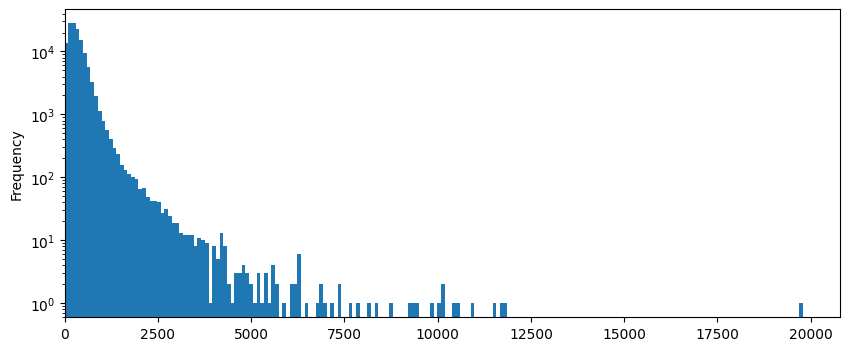

In [9]:
s = sample['content'].str.split().str.len()
plt.figure(figsize=(10, 4))
s.plot.hist(bins=200)
plt.xlim(0)
plt.yscale('log')
print("Total words:",s.sum())

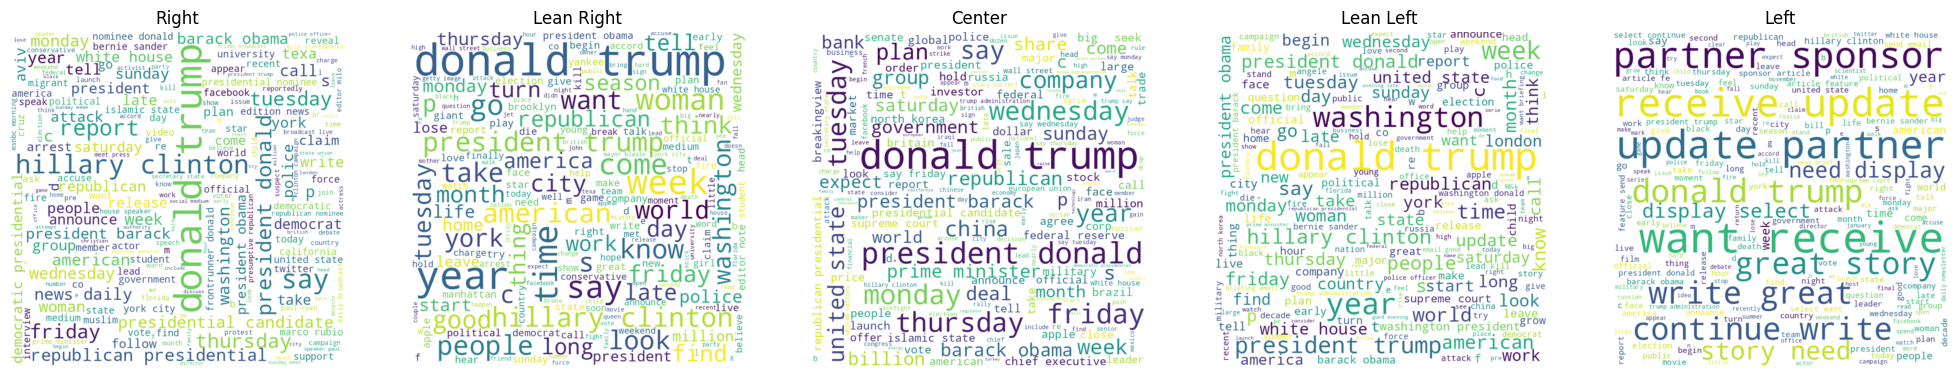

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

right_wing = sample['content'][sample['bias']=="Right"].to_string()
wordcloud_right = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(right_wing)
left_wing = sample['content'][sample['bias']=="Left"].to_string()
wordcloud_left = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(left_wing)
lean_right_wing = sample['content'][sample['bias']=="Lean Right"].to_string()
wordcloud_lean_right = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(lean_right_wing)
lean_left_wing = sample['content'][sample['bias']=="Lean Left"].to_string()
wordcloud_lean_left = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(lean_left_wing)
center_wing = sample['content'][sample['bias']=="Center"].to_string()
wordcloud_center = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(center_wing)

# Plotting the WordCloud images
plt.figure(figsize=(25, 5))

clouds = [
    (wordcloud_right, "Right"),
    (wordcloud_lean_right, "Lean Right"),
    (wordcloud_center, "Center"),
    (wordcloud_lean_left, "Lean Left"),
    (wordcloud_left, "Left"),
]

for i, (wc, title) in enumerate(clouds, 1):
    plt.subplot(1, 5, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

# plt.tight_layout()
plt.savefig("wordcloud.png", dpi=300)
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

x_sample = sample['content']
y_sample = le.fit_transform(sample['bias'])  # use same encoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train_X, test_X, train_Y, test_Y = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

In [12]:
from transformers import DistilBertTokenizerFast
from datasets import Dataset
import multiprocessing

# CPU cores for parallelism
NUM_CORES = multiprocessing.cpu_count()

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_dict({"text": train_X.tolist(), "label": train_Y.tolist()})
test_dataset = Dataset.from_dict({"text": test_X.tolist(), "label": test_Y.tolist()})

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Fast batch tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512  # adjust if texts are long
    )

# Apply tokenization in parallel
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=NUM_CORES)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=NUM_CORES)

# Format for TensorFlow
train_dataset.set_format(type="tf", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="tf", columns=["input_ids", "attention_mask", "label"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/106001 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/26501 [00:00<?, ? examples/s]

2026-01-08 21:44:10.164675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767908650.640501      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767908650.786328      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767908651.928074      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767908651.928106      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767908651.928109      24 computation_placer.cc:177] computation placer alr

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Training setup
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=True
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # you can add metrics if needed
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_24/3562530300.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:

# Train
trainer.train()

wandb: setting up run uog8grzf
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20260108_214437-uog8grzf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run true-snowflake-8
wandb: ⭐️ View project at https://wandb.ai/rijulpaul-none/huggingface
wandb: 🚀 View run at https://wandb.ai/rijulpaul-none/huggingface/runs/uog8grzf
I0000 00:00:1767908679.469968      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13650 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767908679.473947      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalar

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.698600,0.643717,0.759141,0.766128,0.759141,0.756631
2,0.571200,0.563349,0.787593,0.789693,0.787593,0.785076
3,0.501800,0.558817,0.786574,0.805425,0.786574,0.785273
4,0.455100,0.517301,0.807932,0.812071,0.807932,0.805115
5,0.420400,0.508703,0.811705,0.817006,0.811705,0.810126


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2075, training_loss=0.5747068566012096, metrics={'train_runtime': 15924.5984, 'train_samples_per_second': 33.282, 'train_steps_per_second': 0.13, 'total_flos': 7.02121398252288e+16, 'train_loss': 0.5747068566012096, 'epoch': 5.0})

In [15]:
# Evaluate
eval_results = trainer.evaluate()
distilbert_accuracy = eval_results['eval_accuracy']

print(eval_results)
print(f"DistilBERT Accuracy: {distilbert_accuracy}")

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.5087032914161682, 'eval_accuracy': 0.8117052186709935, 'eval_precision': 0.8170061583346637, 'eval_recall': 0.8117052186709935, 'eval_f1': 0.8101257123686536, 'eval_runtime': 270.6077, 'eval_samples_per_second': 97.931, 'eval_steps_per_second': 0.769, 'epoch': 5.0}
DistilBERT Accuracy: 0.8117052186709935


In [16]:
trainer.save_model("news_bias_model")
tokenizer.save_pretrained("news_bias_model")

('news_bias_model/tokenizer_config.json',
 'news_bias_model/special_tokens_map.json',
 'news_bias_model/vocab.txt',
 'news_bias_model/added_tokens.json',
 'news_bias_model/tokenizer.json')